In [1]:
import mne
mne.set_log_level('error')  # reduce extraneous MNE output

# Participant ID code
# p_id = 'N400_dataset_04'
# p_id = 'KERP_13_post'
p_id = 'KERP_19 post'
data_dir = 'data'
raw_file = data_dir + '/' + p_id + '.vhdr'
raw = mne.io.read_raw_brainvision(raw_file, preload=True)

# Set electrode locations
montage = 'standard_1005' # Electrode position file
raw.set_montage(montage)



<RawBrainVision | KERP_19 post.eeg, 16 x 533220 (1066.4 s), ~65.1 MB, data loaded>

In [2]:
# Filter settings
ica_low_cut = 1.0       # For ICA, we filter out more low-frequency power
hi_cut  = 30

raw_ica = raw.copy().filter(ica_low_cut, hi_cut)

In [3]:
# Break raw data into 1 s epochs
tstep = 1.0
events_ica = mne.make_fixed_length_events(raw_ica, duration=tstep)
epochs_ica = mne.Epochs(raw_ica, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)
epochs_ica


Number of events,1066
Events,1: 1066
Time range,0.000 – 1.000 s
Baseline,off


In [4]:
from autoreject import get_rejection_threshold

reject = get_rejection_threshold(epochs_ica);
reject

Estimating rejection dictionary for eeg


{'eeg': 9.801609390972915e-05}

In [5]:
tmp = mne.Epochs(raw, events_ica, tmin=0.0, tmax=tstep,
           baseline=None, reject=reject,
           preload=True)

tmp


Number of events,730
Events,1: 730
Time range,0.000 – 1.000 s
Baseline,off


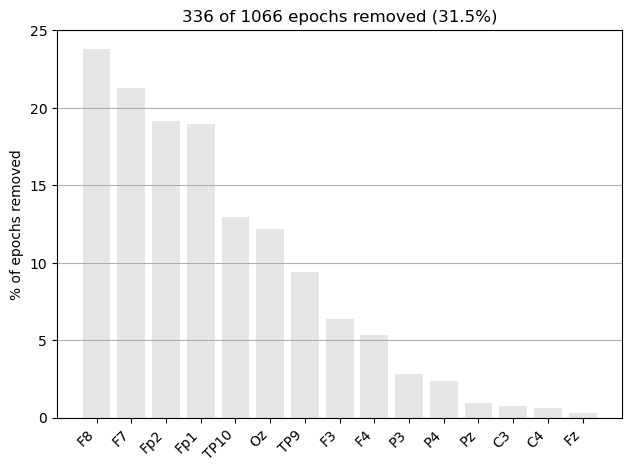

In [6]:
tmp.plot_drop_log();

In [7]:
epochs_ica

Number of events,1066
Events,1: 1066
Time range,0.000 – 1.000 s
Baseline,off


In [8]:
from autoreject import AutoReject

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                picks=mne.pick_types(epochs_ica.info, 
                                     eeg=True,
                                     eog=False
                                    ),
                n_jobs=-1, 
                verbose=False
                )
ar.fit(epochs_ica)
reject_log = ar.get_reject_log(epochs_ica)

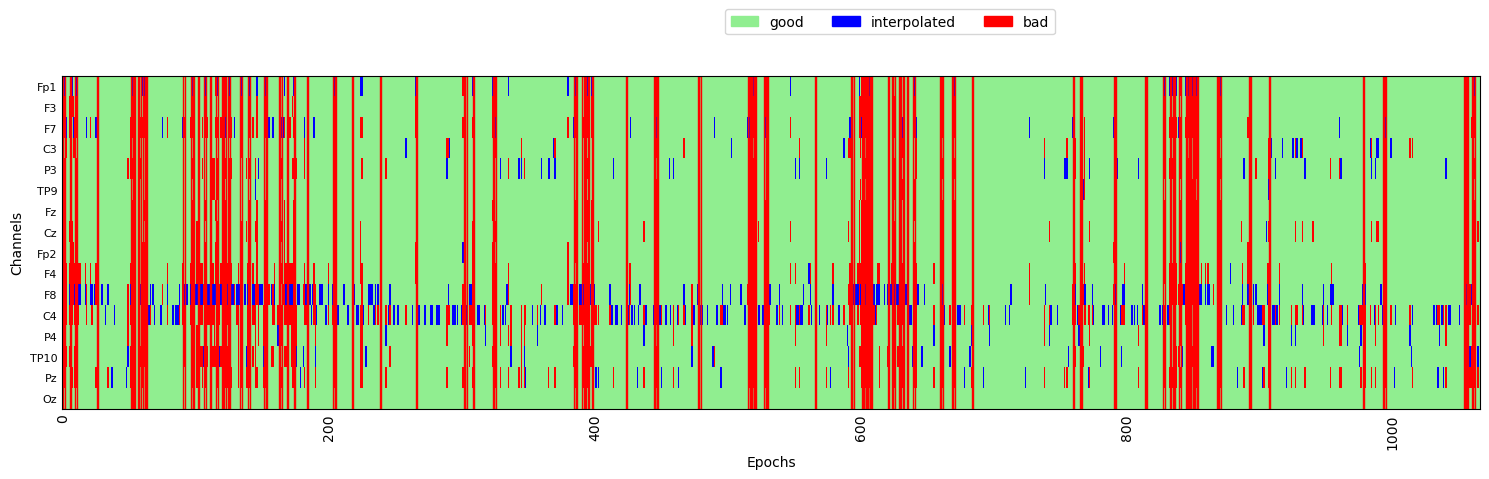

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=[15, 5])
reject_log.plot('horizontal', ax=ax, aspect='auto')
plt.show()

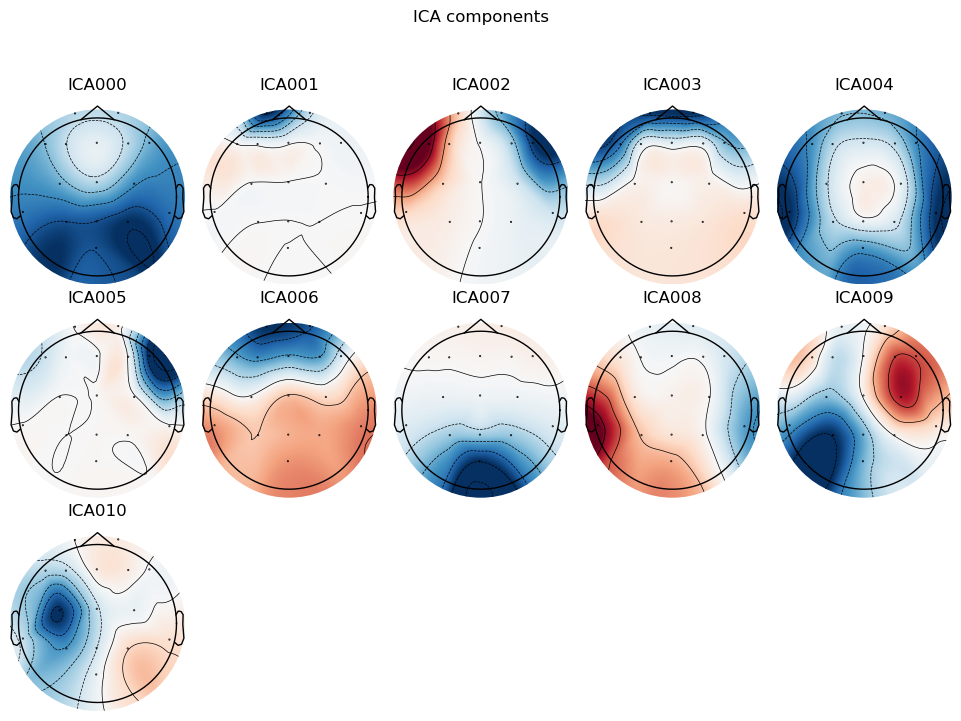

In [10]:
# ICA parameters
random_state = 42   # ensures ICA is reproducible each time it's run
ica_n_components = .99     # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica = mne.preprocessing.ICA(n_components=ica_n_components,
                            random_state=random_state,
                            )
ica.fit(epochs_ica[~reject_log.bad_epochs],
        tstep=tstep)
ica.plot_components();

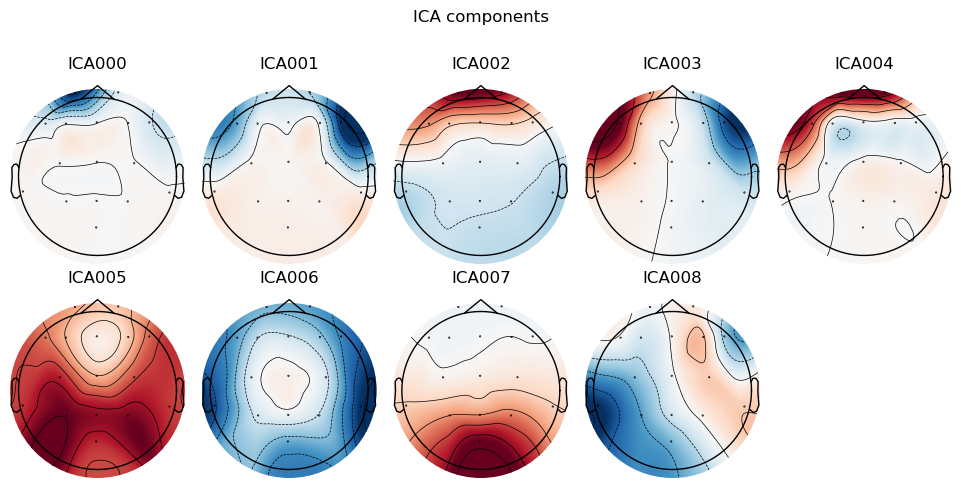

In [11]:
# ICA parameters
random_state = 42   # ensures ICA is reproducible each time it's run
ica_n_components = .99     # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica = mne.preprocessing.ICA(n_components=ica_n_components,
                            random_state=random_state,
                            )
ica.fit(epochs_ica,
        reject=reject,
        tstep=tstep)
ica.plot_components();